# Anomaly Detection with RNN

In this notebook I will show a use recurrent neural network (RNN) for anomaly detection in time-series data. 

Anomaly detection is basically a task of identifying some suspicious  events or items  that differ significantly from the majority.
These suspicious events or items usually lead to some problem like fraud in banking transactions, defect in sensoring machine,  errors in some text data etc. There is however no single  algorithm that can fit for all cases! we  simply need many experiments and explorations to determine the best way of performing anomaly detection.
Thus I personally think it is without doubt  a challenging, yet important, task in data engineering.

RNN, especially  the one that utilizes long short-term memory (LSTM),   is a powerful framework in machine learning.  It can be used for forecasting in time series data. We can build an RNN and train it point by point. The model then is able to generate  new points based on the data it has learned. One characteristic of RNN that differs from other   neural networks is that it can understand each datapoint based on its understanding of previous data points. It  can remembers information for some  periods of time,  even for a very long one if we use LSTM.

Now the question is, how can we use RNN for anomaly detection? Basically it is very simple. For a given time-series data,  first, we can use RNN  to build a  model to predict the next few steps. We can then compare the prediction data with  the actual data. If we have a high error in prediction in some point, then we can suspect  an indication of anomaly.

To exemplify this 
I will perform an anomaly detection by considering a dataset of CPU utilization overtime.The dataset basically contains  a
percentage of CPU utilization per-minute.  I will build the neural network using PyTorch and use Numpy for some basic computation. I also use pandas to load the data and matplotlib for plotting the data.

In [107]:
!pip install torch

import numpy as np
import torch
from torch import nn 
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

# mount my Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


.

## Data Loading and Preprocessing

First I  load the data. It  is available on the file: data.csv. I print the first 50 points. The dataset itself consists of  660 data points.

In [108]:
data = pd.read_csv('/content/drive/My Drive/data.csv', parse_dates=[0], infer_datetime_format=True)
data_cpu = data['cpu'].as_matrix()
data_cpu[:50]

array([1.14, 1.1 , 1.09, 1.08, 1.08, 1.08, 1.15, 1.13, 1.09, 1.06, 1.04,
       1.03, 1.01, 1.  , 0.99, 0.98, 0.97, 0.95, 0.93, 0.92, 0.9 , 0.88,
       0.88, 0.87, 0.85, 0.89, 0.86, 0.84, 0.81, 0.79, 0.78, 0.76, 0.74,
       0.72, 0.71, 0.71, 0.69, 0.68, 0.67, 0.65, 0.65, 0.64, 0.64, 0.64,
       0.67, 0.65, 0.7 , 0.66, 0.63, 0.61])

In [109]:
print('Number of data points: ', len(data_cpu))

Number of data points:  660


I will use the first 500 data points for training. Let us plot these points to get an overview.



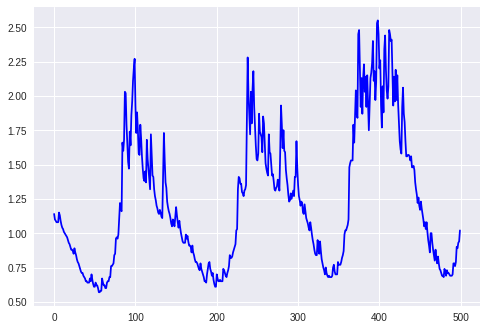

In [110]:
time = np.arange(0,660,1)

plt.figure()
plt.plot(time[:500], data_cpu[:500], 'blue', label='data') # x 
plt.show()

It seems that there is a periodic pattern in the dataset. The peaks of CPU utilization are
roughly every 150  minutes. However note that the data is not standardized. Its mean and standard deviation are clearly not 0 and 1 respectively. 
It is a common practice in many deep learning techniques to standardized the data before training. 
It will help the model to train better. Thus in the following  I   define the standardize function and apply it to our dataset.

In [0]:
def standardize(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result 
  
data_cpu = standardize(data_cpu)  

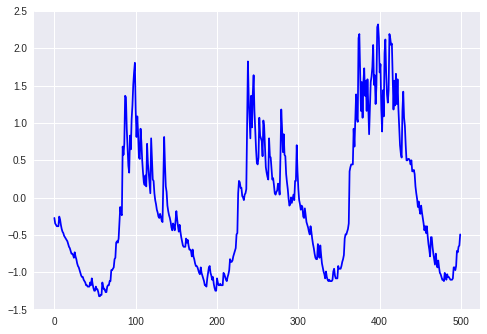

In [112]:
plt.figure()
plt.plot(time[:500], data_cpu[:500], 'blue', label='data') # x 
plt.show()

## Defining the Model

I want my model to behave as follows. Given a sequence of data points as an input, it should
give me as an output  that input sequence but  shifted by one time step further.
For example, given an input sequence: point1, point2, $\ldots$, point10,  my model should output
the sequence: point2, point3, $\ldots$, point11.

### Network Architecture 

I define my model to consists of three kinds of layers: an LSTM layer, a dropout layer, and a fully-connected layer.
First the input sequence that I gave should be passed  to LSTM cells in the LSTM layer.The LSTM cells then will add recurrent connections to the network and give us the ability to include information about the sequence of data points in the CPU utilization data.
After  the LSTM layer,  the output is passed to  a dropout layer to prevent us from overfitting. 
Finally the output  goes to a fully connected layer.  

I define the network in PyTorch. I will use nn.LSTM to create an LSTM layer. An LSTM basically takes these parameters:
* input_size - the size of the input 
* n_hidden - the number of features in the LSTM output and in the hidden state
* n_layers - the number of layers that make up the LSTM,  greater than 1 means that I create a stacked LSTM
* dropout - dropout probability (for dropout between multiple layers)
* batch_first - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, n_hidden)



 

In [0]:
class RNN(nn.Module):
    
    def __init__(self, input_size, output_size, n_hidden, n_layers,
                               drop_prob=0.2):
        super().__init__() 
        self.n_hidden = n_hidden  
                 
        # define the LSTM
        self.lstm = nn.LSTM(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        # define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, output_size)
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        # Get the outputs and the new hidden state from the lstm
        r_out, hidden = self.lstm(x, hidden)
        
        
        # Stack up LSTM outputs using view
        # use contiguous to reshape the output
        r_out = r_out.contiguous().view(-1, self.n_hidden)
        
        
        # pass through a dropout layer
        out = self.dropout(r_out)
        
        #  put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden 
        

### Network Instantiation

Now, I will instantiate the network. I first define the hyperparameters.
* input_size: Size of input for each LSTM cells. I will input a number for each LSTM cells. Thus, it should be 1.
* output_size: Size of the desired output. since I expect   a number as a final output of each LSTM cells, this  should also be 1.
* n_hidden: Number of units in the hidden layers oft the LSTM cells. Typically it is  128, 256,  etc, and a larger number has better performance.
* n_layers: Number of LSTM layers in the network. Typically it is 1,2,  or 3, and a larger number also has better performance. 


In [114]:
# hyperparameters
input_size=1 
output_size=1
n_hidden=128
n_layers=3

# instantiate an RNN
rnn = RNN(input_size, output_size, n_hidden, n_layers)
print(rnn)

RNN(
  (lstm): LSTM(1, 128, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


Now I will separate the data into the training and testing dataset. I first define the function `get_batches` to return batches of size `batch_size`. Each batch contains subsequences of  length `seq_length`. I then use it to get iterators for training and testing. 

In [0]:
def get_batches(arr, batch_size, seq_length, random=False):
  '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array I want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
  sequences  = []
  for n in range(len(arr)-seq_length):
    sequences.append(arr[n:n+ seq_length+1])
    
  seqs = np.array(sequences)
  if random:
    np.random.shuffle(seqs)
  
  n_batches = len(seqs)//batch_size
  
  for n in range(n_batches):
    d = seqs[n:n+batch_size]
    yield d[:,:-1], d[:,1:]

In [0]:
seq_len = 100
batch_size = 50
arr_train = data_cpu[0:500]
arr_test = data_cpu[400:660]

## Training the Model

Now I define how we train the model. For recurrent models, it is common to use an  Adam optimizer.
Note also that this is a regression problem. The data points are coordinate values and we want to compare the prediction points with
the actual one. So I will use a regression loss function, the mean squared error. 
After calculating the loss, as usual I perform backpropagation. I also define the learning rate for the optimizer to be 0.01.  

Moreover before I loop  over a batch of training data, I consider the hidden state to be `None` and
    after a new hidden state is generated by the model, I get the latest hidden state, and use that as input to the rnn for the  next steps.

 

In [118]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)


print_every = 5
epochs = 3 
  
for e in range(epochs):  
  # initialize the hidden state
  hidden = None
  counter = 0
  print('Epoch',e+1)
  for x, y in get_batches(arr_train,batch_size, seq_len, random=True):
        # defining the training data 
        y = y.reshape((-1, 1)) # input_size=1

        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(2) # unsqueeze gives a 1, input_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, I don't backpropagate through the entire history
        
        hidden = tuple([each.data for each in hidden]) 

        
        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if counter%print_every == 0:        
            print('Loss: ', loss.item())
        counter +=1

Epoch 1
Loss:  0.7722095847129822
Loss:  0.4376172125339508
Epoch 2
Loss:  0.39485013484954834
Loss:  0.1602543741464615
Epoch 3
Loss:  0.14885982871055603
Loss:  0.09153346717357635


## Anomally Detection by Forecasting

Now the model is trained. I want tomake prediction by using the model. First I define the function `predict` such that if I  pass in a sequence of points and a network,  the network will predict the next point.  I then use this function to  predict the points501, points 501, $\ldots $, points660.

In [0]:
def predict(net, seq):
        ''' Given a point predict the next point.
            Returns the predicted point
        '''
        
        # tensor inputs
        x = np.array([seq]) 
        inputs = torch.Tensor(x).unsqueeze(2)
        
        # get the output of the model
        out, h = net(inputs, None) 
        
        output = out.data.numpy().flatten()
        next_point = output[-1]
        # return the  value of the predicted point and the hidden state
        return next_point

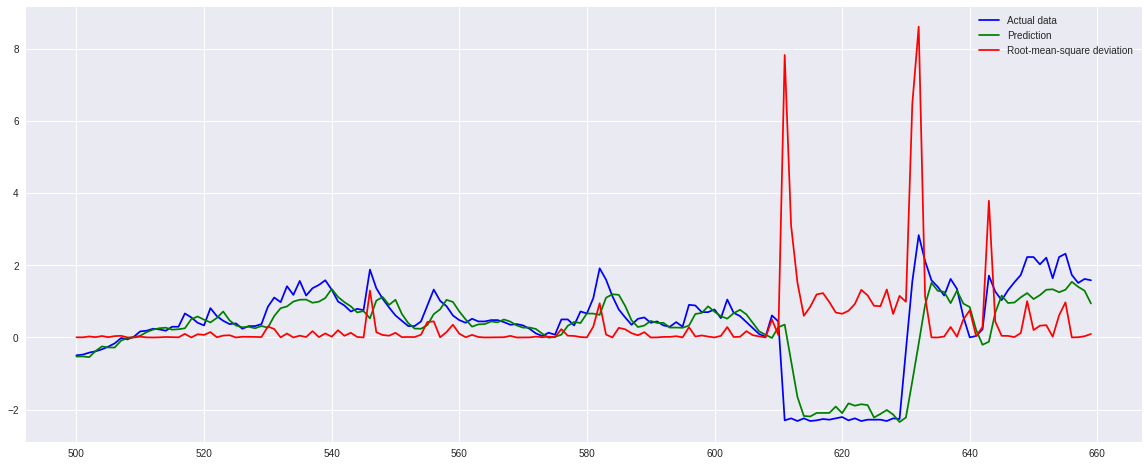

In [124]:
prediction = []
for x, y in get_batches(data_cpu[400:660], 1, 100, random=False):
  prediction.append(predict(rnn,x[0]))

plt.figure(figsize=(20,8))
plt.plot(time[500:660], data_cpu[500:660], 'blue', label='Actual data') # input
plt.plot(time[500:660], prediction, 'green', label='Prediction') # predictions
plt.plot(time[500:660],((data_cpu[500:660]- perkiraan) ** 2), 'red', label='Root-mean-square deviation')
plt.legend()
plt.show()
  

We can see that the prediction is quite close to the actual data. This hint us that the LSTM network  indeed works well. When
the anomaly events happen, we can see a large deviation between the actual data and
predicted one. We can see this in the plot of the root-mean-square. In the 610-th minutes, 
it is acceptable to raise a signal that
anomalies are detected.  

## Summary

I have shown that forecasting with RNN can be used to perform  anomaly detection. 
There os of course other forecasting method that can be used for this, such as ARIMA. 
However  note that forecasting  method in general will not work  well if our 
training data indeed also contains anomalies. It is difficult to
detect anomalies because the model will understand it as a usual behaviour.   In such a case 
we  better  use another method of anomaly detection other  than forecasting like statistical metric or
unsupervised learning.